In [1]:
%load_ext autoreload
%autoreload 2

In [43]:
from pathlib import Path
import yaml
import logging
import uuid
from importlib import import_module


try:
    from .exceptions import PluginError, ImageError, PluginTimeoutError, FileError, ConfigurationError
    from .base_plugin import BasePlugin
except ImportError:
    # support jupyter developement
    from exceptions import PluginError, ImageError, PluginTimeoutError, FileError, ConfigurationError
    from base_plugin import BasePlugin

In [44]:
logger = logging.getLogger(__name__)

In [45]:
import logging
import sys

# Configure logging to show in Jupyter Notebook
def setup_notebook_logging(level=logging.DEBUG):
    log_format = '%(asctime)s [%(levelname)s] [%(name)s] - %(message)s'
    
    # Clear any existing handlers to prevent duplicate logging
    for handler in logging.root.handlers[:]:
        logging.root.removeHandler(handler)

    # Set up logging for notebook
    logging.basicConfig(
        level=level,
        format=log_format,
        handlers=[logging.StreamHandler(sys.stdout)]
    )
    
    logging.getLogger(__name__).info("Notebook logging configured.")

# Run this cell to enable logging
setup_notebook_logging()

2024-12-29 18:05:13,569 [INFO] [__main__] - Notebook logging configured.


In [100]:
import yaml
from pathlib import Path
import logging


class PluginManager:
    def __init__(
        self,
        config: dict = None,
        plugin_path: Path = None,
        config_path: Path = None,
        main_schema_file: str = None,
        plugin_schema_file: str = None,
    ):
        self._config = {}
        self._configured_plugins = []        
        self.plugin_path = plugin_path
        self.config_path = config_path
        self.main_schema_file = main_schema_file
        self.plugin_schema_file = plugin_schema_file
        self._main_schema = None
        self._plugin_schema = None

        # Initialize config if provided
        if config:
            self.config = config

        logger.debug("PluginManager initialized with default values.")

    @property
    def config(self):
        return self._config

    @config.setter
    def config(self, value):
        if not isinstance(value, dict):
            raise TypeError("Config must be a dictionary.")
        
        schema = self.main_schema
        if schema:
            logger.info("Validating config against main schema...")
            self._validate_config(value, schema)

        self._config = value
        logger.info("Configuration successfully updated.")

    @property
    def config_path(self):
        return self._config_path

    @config_path.setter
    def config_path(self, value):
        if not value:
            logger.warning("Config path set to None. Schema loading disabled.")
            self._config_path = None
            return

        if not isinstance(value, Path):
            value = Path(value)

        if not value.is_dir():
            raise FileNotFoundError(f"Config directory not found at {value}")

        self._config_path = value
        self._main_schema = None
        self._plugin_schema = None
        logger.info(f"Config path set to {self._config_path}")

    @property
    def plugin_path(self):
        return self._plugin_path

    @plugin_path.setter
    def plugin_path(self, value):
        if not value:
            logger.warning("Plugin path set to None.")
            self._config_path = None
            return

        if not isinstance(value, Path):
            value = Path(value)

        if not value.is_dir():
            raise FileNotFoundError(f"Plugin directory not found at {value}")

        self._plugin_path = value
        logger.info(f"Plugin path set to {self._plugin_path}")
    
    @property
    def main_schema(self):
        if self._main_schema is None:
            if not self._config_path or not self.main_schema_file:
                logger.warning("Config path or main schema file not set.")
                return {}

            schema_file = self._config_path / self.main_schema_file
            if not schema_file.is_file():
                raise FileNotFoundError(f"Main schema file not found at {schema_file}")

            logger.info(f"Loading main config schema from {schema_file}")
            with open(schema_file, "r") as f:
                self._main_schema = yaml.safe_load(f)
        return self._main_schema

    @property
    def plugin_schema(self):
        if self._plugin_schema is None:
            if not self._config_path or not self.plugin_schema_file:
                logger.warning("Config path or plugin schema file not set.")
                return {}

            schema_file = self._config_path / self.plugin_schema_file
            if not schema_file.is_file():
                raise FileNotFoundError(f"Plugin schema file not found at {schema_file}")

            logger.info(f"Loading plugin schema from {schema_file}")
            with open(schema_file, "r") as f:
                self._plugin_schema = yaml.safe_load(f)
        return self._plugin_schema

    @property
    def configured_plugins(self):
        return self._configured_plugins

    @configured_plugins.setter
    def configured_plugins(self, value):
        if not isinstance(value, list):
            raise TypeError("configured_plugins must be a list of plugin configurations.")

        for plugin_entry in value:
            if not isinstance(plugin_entry, dict) or 'plugin' not in plugin_entry or 'base_config' not in plugin_entry:
                raise ValueError("Each entry in configured_plugins must be a dict with 'plugin' and 'config' keys.")

            
            # Always assign a new UUID (overwriting existing one)
            plugin_uuid = str(uuid.uuid4())[:8]
            plugin_entry['base_config']['uuid'] = plugin_uuid
            logger.info(f"Assigned UUID {plugin_entry['base_config']['uuid']} to plugin {plugin_entry['plugin']}.")
            
            # Validate the config against the plugin schema
            schema = self.plugin_schema.get('plugin_config', {})
            self._validate_config(plugin_entry['base_config'], schema)

            # final setup and validation
            if not plugin_entry.get('base_config', {}).get('name', None):
                name = plugin_entry.get('plugin') + '-' + plugin_uuid
                logger.info(f'No human readable plugin name set. Using: {name}')
                plugin_entry['base_config']['name'] = plugin_entry.get('plugin')
        
        self._configured_plugins = value
        logger.info("configured_plugins successfully validated and set.")
    
    def reload_schemas(self):
        """
        Force reload of main and plugin schemas.
        """
        self._main_schema = None
        self._plugin_schema = None
        logger.info("Schemas reloaded.")

    def _validate_config(self, config, schema):
        """
        Validate configuration against a schema.
        
        Args:
            config (dict): Configuration to validate.
            schema (dict): Schema to validate against.

        Raises:
            ValueError: If the config does not match the schema.
        """
        errors = []
        
        for key, params in schema.items():
            description = params.get('description', 'No description available')
            if key not in config:
                if params.get('required', False):
                    errors.append(f"{key} is required but missing. Description: {description}")
                else:
                    config[key] = params.get('default')
            else:
                value = config[key]
                expected_type = eval(params['type'])

                # Type check
                if not isinstance(value, expected_type):
                    errors.append(f"{key} must be of type {expected_type.__name__} (got {type(value).__name__}). Description: {description}")

                # Allowed values check
                allowed = params.get('allowed')
                if allowed and value not in allowed:
                    errors.append(f"{key} must be one of {allowed} (got {value}). Description: {description}")

        if errors:
            raise ValueError("Config validation failed:\n" + "\n".join(errors))

        logger.info("Config passed schema validation.")

    def load_plugins(self):
        """
        Locate and load plugins based on the configured_plugins property.
        """
        self.active_plugins = []
        self.dormant_plugins = []
    
        for entry in self.configured_plugins:
            plugin_name = entry['plugin']
            base_config = entry['base_config']
            plugin_params = entry.get('plugin_params', {})  # Defaults to empty if missing
    
            try:
                # Import the plugin module dynamically as part of the plugins package
                module = import_module(f'plugins.{plugin_name}')
    
                # Attach the update function from the module
                if hasattr(module.plugin, 'update_function'):
                    base_config['update_function'] = module.plugin.update_function
                else:
                    logger.warning(f"{plugin_name}: update_function not found. Skipping plugin.")
                    continue
    
                # Load layout (if specified) from the plugin module
                if 'layout' in base_config:
                    layout_name = base_config['layout']
                    if hasattr(module.layout, layout_name):
                        layout = getattr(module.layout, layout_name)
                        base_config['layout'] = layout
                    else:
                        raise AttributeError(f"Layout '{layout_name}' not found in {plugin_name}")
                else:
                    logger.warning(f"{plugin_name} is missing a configured layout. Skipping plugin.")
                    continue
    
                # Instantiate BasePlugin with **base_config and pass plugin_params to config
                plugin_instance = BasePlugin(
                    **base_config,
                    config=plugin_params  # Pass plugin_params as config
                )
    
                plugin_instance.update_function = base_config['update_function']
    
                # Sort into active or dormant
                if base_config.get('dormant', False):
                    self.dormant_plugins.append(plugin_instance)
                    logger.info(f"Loaded dormant plugin: {plugin_name}")
                else:
                    self.active_plugins.append(plugin_instance)
                    logger.info(f"Loaded active plugin: {plugin_name}")
    
            except ModuleNotFoundError as e:
                logger.warning(f"Error: {e} while loading {plugin_name}. Skipping plugin.")
                continue
            except AttributeError as e:
                logger.warning(f"{e}. Skipping plugin: {plugin_name}")
                continue
            except KeyError:
                logger.info(f"{plugin_name}: No module specified, skipping.")
                continue
            except Exception as e:
                logger.error(f"{plugin_name} failed to load due to error: {e}. Skipping plugin.")
                continue
    
        logger.info(f"Loaded {len(self.active_plugins)} active plugins and {len(self.dormant_plugins)} dormant plugins.")

In [101]:
! ln -s ../plugins ./

ln: failed to create symbolic link './plugins': File exists


In [102]:
m = PluginManager()

m.plugin_path = './plugins/'
m.config_path = '../config/'
m.main_schema_file = 'main_schema.yaml'
m.plugin_schema_file = 'plugin_schema.yaml'

config = {
    'display_type': 'L',
    'resolution': (800, 480),
}

configured_plugins = [
    {'plugin': 'basic_clock',
     'base_config': {
        'name': 'Basic Clock',
        'duration': 100,
        'refresh_interval': 60,
        'dormant': False,
        'layout': 'layout',
     }},
    {'plugin': 'word_clock',
        'base_config':{
            'name': 'Word Clock',
            'duration': 130,
            'refresh_interval': 60,
            'layout': 'layout',
        },
        'plugin_params': {
            'foo': 'bar',
            'spam': 7,
            'username': 'Monty'}
    }
]
m.configured_plugins = configured_plugins

m.configured_plugins

m.load_plugins()

2024-12-29 18:46:55,055 [WARNING] [__main__] - Plugin path set to None.
2024-12-29 18:46:55,057 [WARNING] [__main__] - Config path set to None. Schema loading disabled.
2024-12-29 18:46:55,059 [DEBUG] [__main__] - PluginManager initialized with default values.
2024-12-29 18:46:55,061 [INFO] [__main__] - Plugin path set to plugins
2024-12-29 18:46:55,064 [INFO] [__main__] - Config path set to ../config
2024-12-29 18:46:55,067 [INFO] [__main__] - Assigned UUID 2801ad1e to plugin basic_clock.
2024-12-29 18:46:55,069 [INFO] [__main__] - Loading plugin schema from ../config/plugin_schema.yaml
2024-12-29 18:46:55,080 [INFO] [__main__] - Config passed schema validation.
2024-12-29 18:46:55,082 [INFO] [__main__] - Assigned UUID babe1f37 to plugin word_clock.
2024-12-29 18:46:55,084 [INFO] [__main__] - Config passed schema validation.
2024-12-29 18:46:55,085 [INFO] [__main__] - configured_plugins successfully validated and set.
2024-12-29 18:46:55,088 [DEBUG] [base_plugin] - BasePlugin instance

In [89]:
z = m.active_plugins[0]

In [105]:
m.active_plugins[1].config

{'foo': 'bar', 'spam': 7, 'username': 'Monty'}

In [77]:
p = BasePlugin(**z)

2024-12-29 18:14:12,997 [DEBUG] [base_plugin] - BasePlugin instance created.
2024-12-29 18:14:12,998 [DEBUG] [root] - NO MASTER LAYOUT YET
2024-12-29 18:14:13,000 [INFO] [base_plugin] - Unset - Using cache directory: /tmp/BasePlugin_cache/Unset
2024-12-29 18:14:13,004 [INFO] [base_plugin] - Unset - Cache expiration set to 2 days.


In [80]:
p.update()
p.image

2024-12-29 18:28:04,465 [INFO] [base_plugin] - Unset - Running update (force=False)...
2024-12-29 18:28:04,467 [WARNING] [base_plugin] - Unset - Running default update_function. No update provided.
2024-12-29 18:28:04,470 [WARNING] [base_plugin] - Unset - Update failed. No data returned.


2024-12-29 18:06:23,090 [INFO] [base_plugin] - Basic Clock - Skipping update. Need to wait 38.56 seconds.


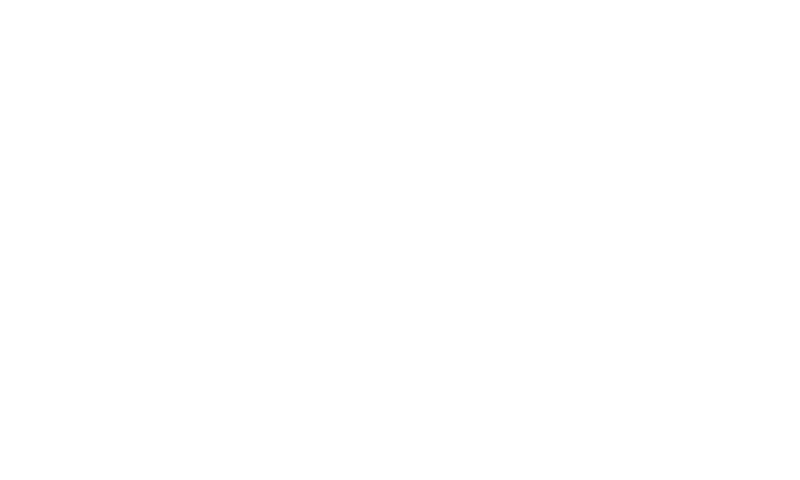

In [53]:
m.active_plugins[0].update()
m.active_plugins[0].image

In [ ]:
hasattr(z.plugin, 'update_function')

In [ ]:
z.plugin.

In [ ]:
z = '.'.join([m.plugin_path.name, 'word_clock'])
q = import_module(z)

In [ ]:
hasattr(q.plugin, 'update_function')

In [ ]:
q.layout.layout

In [ ]:
def load_plugins(self):
    """
    Locate and load plugins based on the configured_plugins property.
    """
    active_plugins = []
    dormant_plugins = []

    for entry in self.configured_plugins:
        plugin = entry['plugin']
        plugin_config = entry['config']
        plugin_name = plugin_config['name']
        plugin_path = self.plugin_path / plugin 
        plugin_file = plugin_path / 'plugin.py'
        logger.info(f"Loading plugin {plugin_name} of type {plugin} in path {plugin_path}")

        if not plugin_path.is_dir() or not plugin_file.is_file():
            logger.warning(f"Plugin {plugin_name} not found at {plugin_dir}. Skipping.")
            continue
        
        try:
            # Import the plugin module dynamically as part of the plugins package
            import_str = '.'.join([self.plugin_path.name, plugin, 'plugin'])
            module = import_module(import_str)
        except Exception as e:
            logger.warning(e)

    #         # Attach the update function from the module
    #         if hasattr(module, 'update_function'):
    #             plugin_config['update_function'] = module.update_function
    #         else:
    #             logger.warning(f"{plugin_name}: update_function not found. Skipping plugin.")
    #             continue

    #         # Load layout (if specified) from the plugin module
    #         if 'layout' in plugin_config:
    #             layout_name = plugin_config['layout']
    #             if hasattr(module.layout, layout_name):
    #                 layout = getattr(module.layout, layout_name)
    #                 plugin_config['layout'] = layout
    #             else:
    #                 raise AttributeError(f"Layout '{layout_name}' not found in {plugin_name}")

    #         # Instantiate BasePlugin and assign update_function
    #         plugin_instance = BasePlugin(
    #             name=plugin_config.get('name', plugin_name),
    #             duration=plugin_config.get('duration', 60),
    #             config=plugin_config,
    #             refresh_interval=plugin_config.get('refresh_interval', 30),
    #             force_onebit=plugin_config.get('force_onebit', False),
    #             cache_dir=plugin_config.get('cache_dir', None)
    #         )
    #         plugin_instance.update_function = plugin_config['update_function']

    #         # Sort into active or dormant
    #         if plugin_config.get('dormant', False):
    #             self.dormant_plugins.append(plugin_instance)
    #             logger.info(f"Loaded dormant plugin: {plugin_name}")
    #         else:
    #             self.active_plugins.append(plugin_instance)
    #             logger.info(f"Loaded active plugin: {plugin_name}")

    #     except ModuleNotFoundError as e:
    #         logger.warning(f"Error: {e} while loading {plugin_name}. Skipping plugin.")
    #         continue
    #     except AttributeError as e:
    #         logger.warning(f"{e}. Skipping plugin: {plugin_name}")
    #         continue
    #     except KeyError:
    #         logger.info(f"{plugin_name}: No module specified, skipping.")
    #         continue
    #     except Exception as e:
    #         logger.error(f"{plugin_name} failed to load due to error: {e}. Skipping plugin.")
    #         continue

    # logger.info(f"Loaded {len(self.active_plugins)} active plugins and {len(self.dormant_plugins)} dormant plugins.")

In [ ]:
class dummy:
    def __init__(self):
        pass
c = dummy()
c.configured_plugins = m.configured_plugins
c.plugin_path = m.plugin_path
load_plugins(c)

In [ ]:

# self.update_function = self.default_update_function
# self.name = name
# self.duration = duration
# self.refresh_interval = refresh_interval
# self.plugin_timeout = plugin_timeout
# self.dormant = dormant
# self.last_updated = 0
# self.active = False
# self.resolution = resolution
# self.screen_mode = screen_mode
# self.force_onebit = force_onebit
# self.image = None
# self.config = config
# self.data = {}
# self.agent_string = "PaperPi"
# self.layout = layout
# self.update_data = None

In [ ]:
m.validate_config(m.config, m.plugin_manager_schema, 'base plugin schema')

In [ ]:
m.plugin_path

## fix me!

The code below should be used to load configuration from the user/system config and then use it to setup the plugin when it is created.


In [ ]:
    def load_base_schema(self):
        """
        Load and validate base configuration using the global schema at 
        PaperPi/config/plugin_schema.yaml.
        
        Raises:
            PluginError: If base config fails critical validation.
        """
        schema_file = Path(self.base_config_path) / 'plugin_schema.yaml'
        logger.info(f'Loading base plugin schema: {schema_file}')

        if not schema_file.is_file():
            logger.error(f"Base schema {schema_file} missing. Cannot proceed.")
            raise FileError("Base schema is required but missing.")

        try:
            with open(schema_file, 'r') as f:
                schema = yaml.safe_load(f)

            base_schema = schema.get('base_config', {})
            if not base_schema:
                raise ConfigurationError(f'Error locating "base_config" section in {schema_file}')
            self.validate_schema(self.config, base_schema, "Base Config")

        except Exception as e:
            msg = f"{self.name} - Error loading base schema: {e}"
            logger.error(msg)
            raise PluginError(msg, plugin_name=self.name)

    def load_plugin_schema(self):
        """
        Load and validate plugin configuration using plugin_config.yaml
        in the plugin directory.
        
        Raises:
            PluginError: If plugin config fails validation.
        """
        schema_file = self.plugin_path / 'plugin_config.yaml'

        if not schema_file.is_file():
            logger.warning(f"{self.name} - plugin_config.yaml not found. Skipping plugin config validation.")
            return

        try:
            with open(schema_file, 'r') as f:
                schema = yaml.safe_load(f)

            plugin_schema = schema.get('plugin_config', {})
            # additional configuration is not required for plugins
            if plugin_schema:
                self.validate_schema(self.config, plugin_schema, "Plugin Config")
            else:
                pass

        except Exception as e:
            msg = f"{self.name} - Error loading plugin schema: {e}"
            logger.error(msg)
            raise PluginError(msg, plugin_name=self.name)

    def validate_schema(self, config, schema, schema_name):
        """
        Validate a configuration dictionary against a schema.

        Args:
            config (dict): Configuration to validate.
            schema (dict): Schema for validation.
            schema_name (str): Name of the schema for logging.

        Raises:
            PluginError: If required fields are missing or invalid.
        """
        for key, params in schema.items():
            # Apply defaults if missing
            if key not in config:
                config[key] = params.get('default')
                logger.info(f"{schema_name} - {key} set to default: {config[key]}")

            value = config[key]
            expected_type = eval(params['type'])

            # Type check
            if not isinstance(value, expected_type):
                msg = f"{schema_name} - {key} must be of type {expected_type}."
                logger.error(msg)
                raise PluginError(msg, plugin_name=self.name)

            # Allowed values
            allowed = params.get('allowed')
            if allowed and value not in allowed:
                msg = f"{schema_name} - {key} must be one of {allowed}."
                logger.error(msg)
                raise PluginError(msg, plugin_name=self.name)

            # Required field missing
            if params.get('required') and value is None:
                msg = f"{schema_name} - {key} is required but missing."
                logger.error(msg)
                raise PluginError(msg, plugin_name=self.name)

    def load_update_function(self):
        """
        Dynamically load the update_function from plugin.py in the plugin directory.
        Treats the plugin directory as a package to handle relative imports.
        """
        plugin_name = self.plugin_path.stem  # e.g., 'basic_clock'
        plugin_parent = str(self.plugin_path.parent)  # e.g., ../plugins
    
        if not (self.plugin_path / '__init__.py').is_file():
            msg = f"{plugin_name} - Missing __init__.py. Cannot load plugin as a package."
            logger.error(msg)
            raise PluginError(msg, plugin_name=self.name)
    
        try:
            # Add the parent directory to sys.path for package-level imports
            if plugin_parent not in sys.path:
                sys.path.insert(0, plugin_parent)
    
            # Import the plugin module dynamically as a package
            module = importlib.import_module(f"{plugin_name}.plugin")
    
            if hasattr(module, 'update_function'):
                self.update_function = module.update_function.__get__(self)
                logger.info(f"{plugin_name} - update_function successfully loaded.")
            else:
                msg = f"{plugin_name} - update_function not found in plugin.py"
                logger.error(msg)
                raise PluginError(msg, plugin_name=self.name)
    
        except Exception as e:
            msg = f"{plugin_name} - Failed to load update_function: {e}"
            logger.error(msg)
            raise PluginError(msg, plugin_name=self.name)

In [ ]:

    @property
    def plugin_path(self):
        return self._plugin_path

    @plugin_path.setter
    def plugin_path(self, value):
        if not value:
            self._plugin_path = None
            return
        
        if not isinstance(value, (str, Path)):
            raise TypeError('Must be of type str or Path')
        value = Path(value)
        if not value.is_dir():
            raise FileError('Plugin directory does not exist')

        self._plugin_path = value
        self.load_update_function()
    
